In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from fredapi import Fred
import pingouin as pg
import time
from scipy import stats

# House price and racial demographics in US cities

First, we want to get all the house price data from the FRED API, because there is more than 3000 county in the US, while FRED only has 2000 counties' data. Some of the counties will have less Asian population, which is small enough that we ignore them.

In [12]:
fred = Fred(api_key= 'ecc7334e54825a69e5f1e8e911f9ae03')
search1 = fred.search('All-Transactions House Price Index county', filter =('frequency', 'Annual'), order_by='search_rank')
search2 = fred.search('All-Transactions House Price Index county', filter =('frequency', 'Annual'), order_by='popularity')
search3 = fred.search('All-Transactions House Price Index county', filter =('frequency', 'Annual'), order_by='series_id', sort_order='asc')
search4 = fred.search('All-Transactions House Price Index county', filter =('frequency', 'Annual'), order_by='series_id', sort_order='desc')
search = pd.concat([search1, search2, search3,search4], axis=0).drop_duplicates()
search.shape

(2148, 15)

In [13]:
search['title'] = search.title.str.replace('All-Transactions House Price Index for ','')
county_names = search.title.str.split(',', expand=True)
county_names.rename(columns={0: 'county', 1:'state'}, inplace=True)

In [14]:
search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
ATNHPIUS06037A,ATNHPIUS06037A,2023-06-06,2023-06-06,"Los Angeles County, CA",1975-01-01,2022-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2023-03-28 09:02:02-05:00,51,"As stated by the source, these annual county i..."
ATNHPIUS06059A,ATNHPIUS06059A,2023-06-06,2023-06-06,"Orange County, CA",1975-01-01,2022-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2023-03-28 09:02:03-05:00,40,"As stated by the source, these annual county i..."
ATNHPIUS36119A,ATNHPIUS36119A,2023-06-06,2023-06-06,"Westchester County, NY",1975-01-01,2022-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2023-03-28 09:02:04-05:00,25,"As stated by the source, these annual county i..."
ATNHPIUS53033A,ATNHPIUS53033A,2023-06-06,2023-06-06,"King County, WA",1975-01-01,2022-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2023-03-28 09:01:02-05:00,21,"As stated by the source, these annual county i..."
ATNHPIUS12086A,ATNHPIUS12086A,2023-06-06,2023-06-06,"Miami-Dade County, FL",1975-01-01,2022-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2023-03-28 09:02:05-05:00,18,"As stated by the source, these annual county i..."


In [15]:
# all_results = []
#
# for myid in search['id']:
#     results = fred.get_series(myid)
#     results = results.to_frame(name = myid)
#     all_results.append(results)
#     time.sleep(0.3)
#
# housing_result = pd.concat(all_results, axis = 1)

In [16]:
housing_result = pd.read_csv('uscensus_data_counties/housing_result_2000.csv')

In [17]:
housing_result_t = housing_result.transpose()
housing_result_t = housing_result_t.merge(county_names, left_index = True, right_on = 'series id',)

In [18]:
housing_result_t['p_change'] = (housing_result_t.iloc[:,-3] - housing_result_t.iloc[:,-14])/housing_result_t.iloc[:,-14]*100
housing_p_change = housing_result_t.iloc[:, -3:]

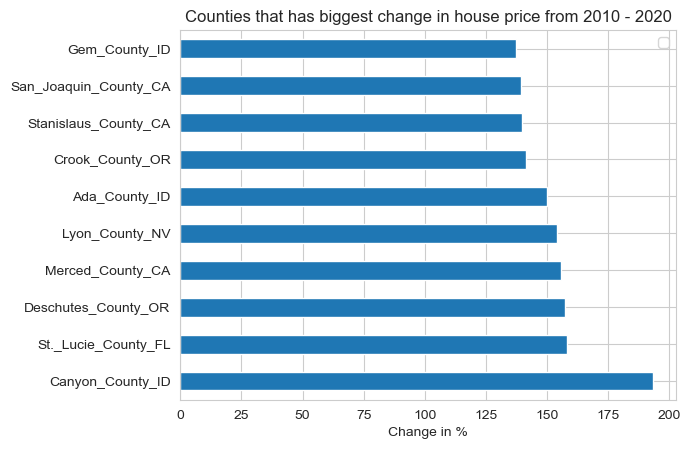

In [19]:
housing_p_change['city_state'] = housing_p_change.county.str.replace(' ','_') + '_' + housing_p_change.state.str.strip()
df = housing_p_change.sort_values(by = 'p_change', ascending = False).head(10)
df.plot(kind = 'barh', x='city_state')
plt.title('Counties that has biggest change in house price from 2010 - 2020')
plt.ylabel(None)
plt.xlabel('Change in %')
plt.legend('')
plt.show()

We didn't consider other factors here, only looking at the change in house price. There are a few states that have shown up a lot. Canyon County, Idaho, has the most significant change, which is around a 190% change in house prices. Counties in Idaho appear 3 times in this graph, the same applies to California, which also appears 3 times, where Merced County ranked No. 4 in the change in house price. Nevada appears 2 times, we will notice that the states like Idaho and Nevada, which are not seen as typical rich states, have some big changes. We will dig deeper after we consider other factors.

## Cleaning all the census data

In [20]:
census_2010 = pd.read_csv('uscensus_data_all/all_2010.csv',low_memory=False)
census_2020 = pd.read_csv('uscensus_data_all/all_2020.csv',low_memory=False)
census_2010_t = census_2010.T
census_2020_t = census_2020.T

In [21]:
hispanic_2010 = pd.read_csv('uscensus_data_all/hispanic_2010.csv',low_memory=False)
hispanic_2020 = pd.read_csv('uscensus_data_all/hispanic_2020.csv',low_memory=False)
hispanic_2010_t = hispanic_2010.T
hispanic_2020_t = hispanic_2020.T

In [22]:
hispanic_2010_t.columns = hispanic_2010_t.iloc[0]
hispanic_2010_t = hispanic_2010_t.drop(hispanic_2010_t.index[0])
hispanic_2020_t.columns = hispanic_2020_t.iloc[0]
hispanic_2020_t = hispanic_2020_t.drop(hispanic_2020_t.index[0])

In [23]:
census_2010_t.columns = census_2010_t.iloc[0]
census_2010_t = census_2010_t.drop(census_2010_t.index[0])
census_2020_t.columns = census_2020_t.iloc[0]
census_2020_t = census_2020_t.drop(census_2020_t.index[0])

In [24]:
%%capture
h_2010 = hispanic_2010_t.reset_index()
h_2020 = hispanic_2020_t.reset_index()
h_2010 = hispanic_2010_t.iloc[:, 1:2]
h_2020 = hispanic_2020_t.iloc[:, 1:2]
h_2010['year'] = 2010
h_2020['year'] = 2020
h_2010 = h_2010.reset_index()
h_2020 = h_2020.reset_index()

In [25]:
%%capture
c_2010 = census_2010_t.iloc[:, :8]
c_2020 = census_2020_t.iloc[:, :8]
c_2010['year'] = 2010
c_2020['year'] = 2020
c_2010 = c_2010.reset_index()
c_2020 = c_2020.reset_index()

In [26]:
hisp = pd.concat([h_2010,h_2020])
hisp.columns = ['city','hisp','year']

In [27]:
hisp = hisp.pivot(index = 'city', columns = 'year')

In [28]:
df = pd.concat([c_2010,c_2020])
df.columns = ['city', 'total','total_one', 'wh','bl','na','as','ha','o','year']

In [29]:
df = df.pivot(index = 'city', columns = 'year', values = ['total','total_one', 'wh','bl','na','as','ha','o'])
# Can't do any calculation on old data, have to transform them.

In [30]:
df = df.merge(hisp, left_index=True, right_index=True, how ='inner')
df.dropna(inplace = True)

For reference, wh is 'White', bl is 'Black', na is 'Native American', as is 'Asian', ha is 'Native Hawaiian and Other Pacific Islander', o is 'Other', hisp is 'Hispanic'

In [31]:
def convert_to_numeric(col):
    return pd.to_numeric(col.str.replace(',', ''), errors='coerce')
df = df.apply(convert_to_numeric)
df.dropna(inplace = True)
# It will automatically drop numbers smaller than 1000, which is what I will do.

In [32]:
df['total_change'] = (df.iloc[:,1] - df.iloc[:,0])/df.iloc[:,0]*100
df['total_1_change'] = (df.iloc[:,3] - df.iloc[:,2])/df.iloc[:,2]*100
df['wh_change'] = (df.iloc[:,5] - df.iloc[:,4])/df.iloc[:,4]*100
df['bl_change'] = (df.iloc[:,7] - df.iloc[:,6])/df.iloc[:,6]*100
df['na_change'] = (df.iloc[:,9] - df.iloc[:,8])/df.iloc[:,8]*100
df['as_change'] = (df.iloc[:,11] - df.iloc[:,10])/df.iloc[:,10]*100
df['ha_change'] = (df.iloc[:,13] - df.iloc[:,12])/df.iloc[:,12]*100
df['o_change'] = (df.iloc[:,15] - df.iloc[:,14])/df.iloc[:,14]*100
df['hisp_change'] = (df.iloc[:,17] - df.iloc[:,16])/df.iloc[:,16]*100

In [33]:
df.reset_index(inplace = True)
df.columns = ['city_state','total_10','total_20','total_one_10', 'total_one_20','wh_10','wh_20','bl_10','bl_20','na_10','na_20','as_10','as_20','ha_10','ha_20','o_10','o_20','hisp_10','hisp_20','total_change','total_1_change','wh_change','bl_change','na_change','as_change','ha_change','o_change','hisp_change']

In [34]:
# Asked ChatGPT to help me create this list to transform full state name to abbreviation
# states = [['Alabama', 'AL'],
#           ['Alaska', 'AK'],
#           ['Arizona', 'AZ'],
#           ['Arkansas', 'AR'],
#           ['California', 'CA'],
#           ['Colorado', 'CO'],
#           ['Connecticut', 'CT'],
#           ['Delaware', 'DE'],
#           ['District of Columbia', 'DC'],
#           ['Florida', 'FL'],
#           ['Georgia', 'GA'],
#           ['Hawaii', 'HI'],
#           ['Idaho', 'ID'],
#           ['Illinois', 'IL'],
#           ['Indiana', 'IN'],
#           ['Iowa', 'IA'],
#           ['Kansas', 'KS'],
#           ['Kentucky', 'KY'],
#           ['Louisiana', 'LA'],
#           ['Maine', 'ME'],
#           ['Maryland', 'MD'],
#           ['Massachusetts', 'MA'],
#           ['Michigan', 'MI'],
#           ['Minnesota', 'MN'],
#           ['Mississippi', 'MS'],
#           ['Missouri', 'MO'],
#           ['Montana', 'MT'],
#           ['Nebraska', 'NE'],
#           ['Nevada', 'NV'],
#           ['New Hampshire', 'NH'],
#           ['New Jersey', 'NJ'],
#           ['New Mexico', 'NM'],
#           ['New York', 'NY'],
#           ['North Carolina', 'NC'],
#           ['North Dakota', 'ND'],
#           ['Ohio', 'OH'],
#           ['Oklahoma', 'OK'],
#           ['Oregon', 'OR'],
#           ['Pennsylvania', 'PA'],
#           ['Rhode Island', 'RI'],
#           ['South Carolina', 'SC'],
#           ['South Dakota', 'SD'],
#           ['Tennessee', 'TN'],
#           ['Texas', 'TX'],
#           ['Utah', 'UT'],
#           ['Vermont', 'VT'],
#           ['Virginia', 'VA'],
#           ['Washington', 'WA'],
#           ['West Virginia', 'WV'],
#           ['Wisconsin', 'WI'],
#           ['Wyoming', 'WY']]
# states_index = pd.DataFrame(states, columns=['Full', 'Abb'])

In [35]:
# df = df.merge(states_index, how = 'left', left_on='state', right_on= 'Full')
# df.drop(columns='Full')
# df['city_state']= df.county.str.replace(' ', '_') + '_' + df.Abb

In [36]:
# combined = df.merge(housing_p_change, how = 'left', left_on= 'city_state', right_on='city_state')

In [37]:
# combined.dropna(inplace = True)
# combined['p_change']=pd.to_numeric(combined['p_change'], errors='coerce')
# combined.drop(columns=['county_y','state_y','Full'], inplace= True)
# combined.rename(columns={'county_x':'county','state_x':'state'}, inplace = True)

In [38]:
# These columns indicate the proportion of population of that race of the county's total population
combined = df
combined['wh_p_10'] = combined['wh_10'] / combined['total_10']*100
combined['wh_p_20'] = combined['wh_20'] / combined['total_20']*100
combined['bl_p_10'] = combined['bl_10'] / combined['total_10']*100
combined['bl_p_20'] = combined['bl_20'] / combined['total_20']*100
combined['na_p_10'] = combined['na_10'] / combined['total_10']*100
combined['na_p_20'] = combined['na_20'] / combined['total_20']*100
combined['as_p_10'] = combined['as_10'] / combined['total_10']*100
combined['as_p_20'] = combined['as_20'] / combined['total_20']*100
combined['ha_p_10'] = combined['ha_10'] / combined['total_10']*100
combined['ha_p_20'] = combined['ha_20'] / combined['total_20']*100
combined['o_p_10'] = combined['o_10'] / combined['total_10']*100
combined['o_p_20'] = combined['o_20'] / combined['total_20']*100
combined['hisp_p_10'] = combined['hisp_10'] / combined['total_10']*100
combined['hisp_p_20'] = combined['hisp_20'] / combined['total_20']*100

In [39]:
# These columns indicate the change in proportion of population of that race
# There might be a change in each race's population in one county, but the population composition may remain the same.
combined['wh_p_change_20'] = combined['wh_p_20'] - combined['wh_p_10']
combined['bl_p_change_20'] = combined['bl_p_20'] - combined['bl_p_10']
combined['na_p_change_20'] = combined['na_p_20'] - combined['na_p_10']
combined['as_p_change_20'] = combined['as_p_20'] - combined['as_p_10']
combined['ha_p_change_20'] = combined['ha_p_20'] - combined['ha_p_10']
combined['o_p_change_20'] = combined['o_p_20'] - combined['o_p_10']
combined['hisp_p_change_20'] = combined['hisp_p_20'] - combined['hisp_p_10']

In [40]:
combined

,city_state,total_10,total_20,total_one_10,total_one_20,wh_10,wh_20,bl_10,bl_20,na_10,...,o_p_20,hisp_p_10,hisp_p_20,wh_p_change_20,bl_p_change_20,na_p_change_20,as_p_change_20,ha_p_change_20,o_p_change_20,hisp_p_change_20
0,"Abbeville city, Alabama",2688.0,2358.0,2657.0,2275.0,1463.0,1165.0,1113.0,1039.0,2.0,...,2.162850,2.492560,3.477523,-5.020807,2.656515,0.137639,-0.331130,0.000000,0.191124,0.984964
1,"Abbeville city, Georgia",2908.0,2685.0,2859.0,2657.0,1191.0,963.0,1624.0,1639.0,3.0,...,1.750466,2.613480,5.698324,-5.090062,5.196888,-0.103164,-0.183479,0.000000,0.821992,3.084844
2,"Abbeville city, Louisiana",12257.0,11186.0,12011.0,10694.0,6132.0,5054.0,5029.0,4776.0,32.0,...,1.832648,3.589785,3.441802,-4.847078,1.666612,0.114394,0.326171,0.008940,0.339624,-0.147983
3,"Abbeville city, South Carolina",5237.0,4874.0,5158.0,4703.0,2458.0,2389.0,2645.0,2275.0,10.0,...,0.492409,0.992935,0.984817,2.079914,-3.829774,-0.088364,-0.275047,0.041034,0.072321,-0.008117
4,"Abbotsford city, Wisconsin",2310.0,2275.0,2298.0,2015.0,1893.0,1500.0,2.0,12.0,8.0,...,20.703297,37.922078,25.406593,-16.013986,0.440892,0.225108,0.142524,0.000000,4.296370,-12.515485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14362,"Zionsville town, Indiana",14160.0,30603.0,13968.0,28767.0,13314.0,26470.0,176.0,587.0,21.0,...,1.012973,7.966102,0.993367,-7.530636,0.675175,0.047754,1.634115,0.018552,0.511560,-6.972735
14363,"Zolfo Springs town, Florida",1827.0,1737.0,1770.0,1235.0,1182.0,704.0,77.0,51.0,10.0,...,25.043178,62.123700,67.760507,-24.166574,-1.278463,1.467623,-0.141516,-0.213266,-1.448338,5.636807
14364,"Zumbrota city, Minnesota",3252.0,3726.0,3196.0,3590.0,3117.0,3451.0,22.0,29.0,15.0,...,1.449275,2.921279,1.422437,-3.229277,0.101808,-0.085517,0.228176,0.161031,0.895770,-1.498842
14365,"Zuni Pueblo CDP, New Mexico",6302.0,6176.0,6241.0,6103.0,72.0,54.0,6.0,4.0,6122.0,...,0.178109,1.840685,2.655440,-0.268142,-0.030441,0.362713,-0.075779,0.000324,-0.202723,0.814755


In [41]:
price_2010 = pd.read_csv('uscensus_data_all/ACSST5Y2010.S2506-Data.csv',header=[0,1],low_memory=False)
price_2020 = pd.read_csv('uscensus_data_all/ACSST5Y2020.S2506-Data.csv',header=[0,1],low_memory=False)
price_2010 = price_2010.iloc[:,[1,34]]
price_2020 = price_2020.iloc[:,[1,34]]

In [42]:
%%capture
price_2020['year'] = 2020
price_2010['year'] = 2010
price_2020.columns = ['city_state','price','year']
price_2010.columns = ['city_state','price','year']
price_2020 = price_2020[price_2020['price']!='-']
price_2010 = price_2010[price_2010['price']!='-']
price = pd.concat([price_2020,price_2010])
price['price'] = pd.to_numeric(price['price'].str.replace(',', '').str.replace('+','').str.replace('-',''), errors='coerce')

In [43]:
price = price.pivot(index = 'city_state', columns = 'year')
price.dropna(inplace = True)

In [44]:
price.columns = ['p_10','p_20']
price['p_change']= (price['p_20']-price['p_10'])/price['p_10']*100

In [45]:
combined = combined.merge(price, left_on= 'city_state', right_index=True, how = 'inner')

Before running all the tests, I realized that, most likely, house prices will increase instead of decrease in most situations throughout 10 years. If you check housing prices from 2000 and 2010, although there was a decrease during the 2008 financial crisis, housing price change is still positive. While everything is positive makes us difficult to find out the difference and impact of demographic change. While looking at the histogram, we can observe a right skewness for house price change. I decide to use the median as the benchmark, if the house price changes larger than the median change, it will be positive, and smaller than the median will become negative. I call it an adjusted price.

In [46]:
combined = combined[~((combined['total_20'] < 2000) & (combined['p_change'] > 200))]
combined = combined[~(combined['p_change'] > 500)]
# Get rid of outliers

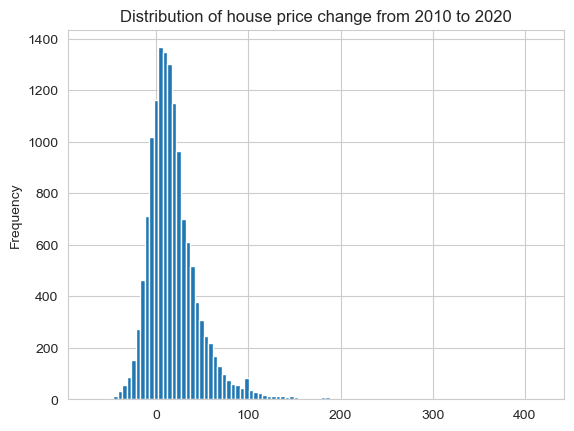

In [47]:
combined.p_change.plot(kind='hist', bins = 100)
plt.title('Distribution of house price change from 2010 to 2020')
plt.show()

In [48]:
combined['adj_p_change'] = combined.p_change - combined.p_change.median()

Finally, we clean up all the data (pivot is difficulty to use in Pandas)

In [49]:
combined.head()

,city_state,total_10,total_20,total_one_10,total_one_20,wh_10,wh_20,bl_10,bl_20,na_10,...,bl_p_change_20,na_p_change_20,as_p_change_20,ha_p_change_20,o_p_change_20,hisp_p_change_20,p_10,p_20,p_change,adj_p_change
0,"Abbeville city, Alabama",2688.0,2358.0,2657.0,2275.0,1463.0,1165.0,1113.0,1039.0,2.0,...,2.656515,0.137639,-0.331130,0.000000,0.191124,0.984964,92900.0,98600.0,6.135630,-7.017080
1,"Abbeville city, Georgia",2908.0,2685.0,2859.0,2657.0,1191.0,963.0,1624.0,1639.0,3.0,...,5.196888,-0.103164,-0.183479,0.000000,0.821992,3.084844,29200.0,53300.0,82.534247,69.381537
2,"Abbeville city, Louisiana",12257.0,11186.0,12011.0,10694.0,6132.0,5054.0,5029.0,4776.0,32.0,...,1.666612,0.114394,0.326171,0.008940,0.339624,-0.147983,76500.0,96900.0,26.666667,13.513957
3,"Abbeville city, South Carolina",5237.0,4874.0,5158.0,4703.0,2458.0,2389.0,2645.0,2275.0,10.0,...,-3.829774,-0.088364,-0.275047,0.041034,0.072321,-0.008117,90200.0,97000.0,7.538803,-5.613907
4,"Abbotsford city, Wisconsin",2310.0,2275.0,2298.0,2015.0,1893.0,1500.0,2.0,12.0,8.0,...,0.440892,0.225108,0.142524,0.000000,4.296370,-12.515485,109900.0,112500.0,2.365787,-10.786922


## Take a look at the big picture of our data

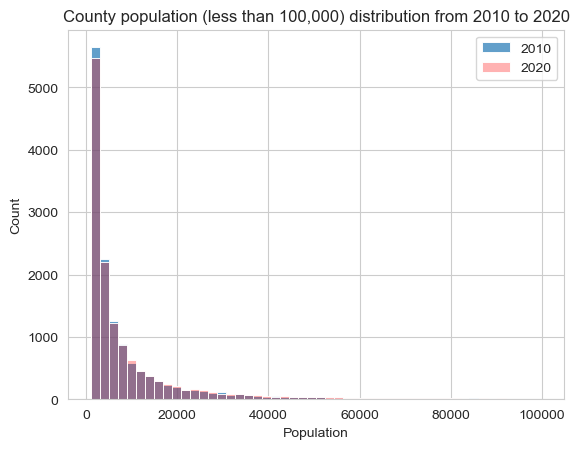

In [50]:
sns.histplot(combined.query("total_10 <100000"), x='total_10', alpha = 0.7, label = '2010', bins = 50)
sns.histplot(combined.query("total_20 <100000"), x='total_20', color = 'red', alpha = 0.3, label = '2020', bins = 50)
plt.legend()
plt.title('County population (less than 100,000) distribution from 2010 to 2020')
plt.xlabel('Population')
plt.ticklabel_format(style='plain', axis='x')

Looks like for counties with a population of less than 1 million, there is a small change. Further range's county numbers can offset with each other.

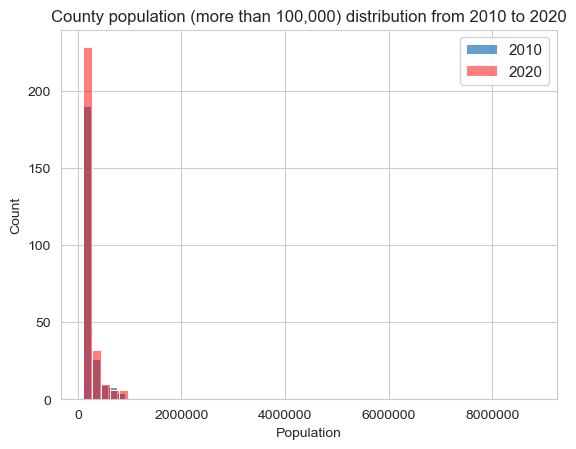

In [51]:
sns.histplot(combined.query("total_10 >100000"), x='total_10', alpha = 0.7, label = '2010', bins = 50)
sns.histplot(combined.query("total_20 >100000"), x='total_20', color = 'red', alpha = 0.5, label = '2020', bins = 50)
sns.set_theme(style="whitegrid", palette=None)
plt.legend()
plt.title('County population (more than 100,000) distribution from 2010 to 2020')
plt.xlabel('Population')
plt.ticklabel_format(style='plain', axis='x')

For counties with a population over 1 million, five more counties show up with a population of around 2 million, and there are 2 new counties with 2.5 million population. Let's take a look at what are these counties:

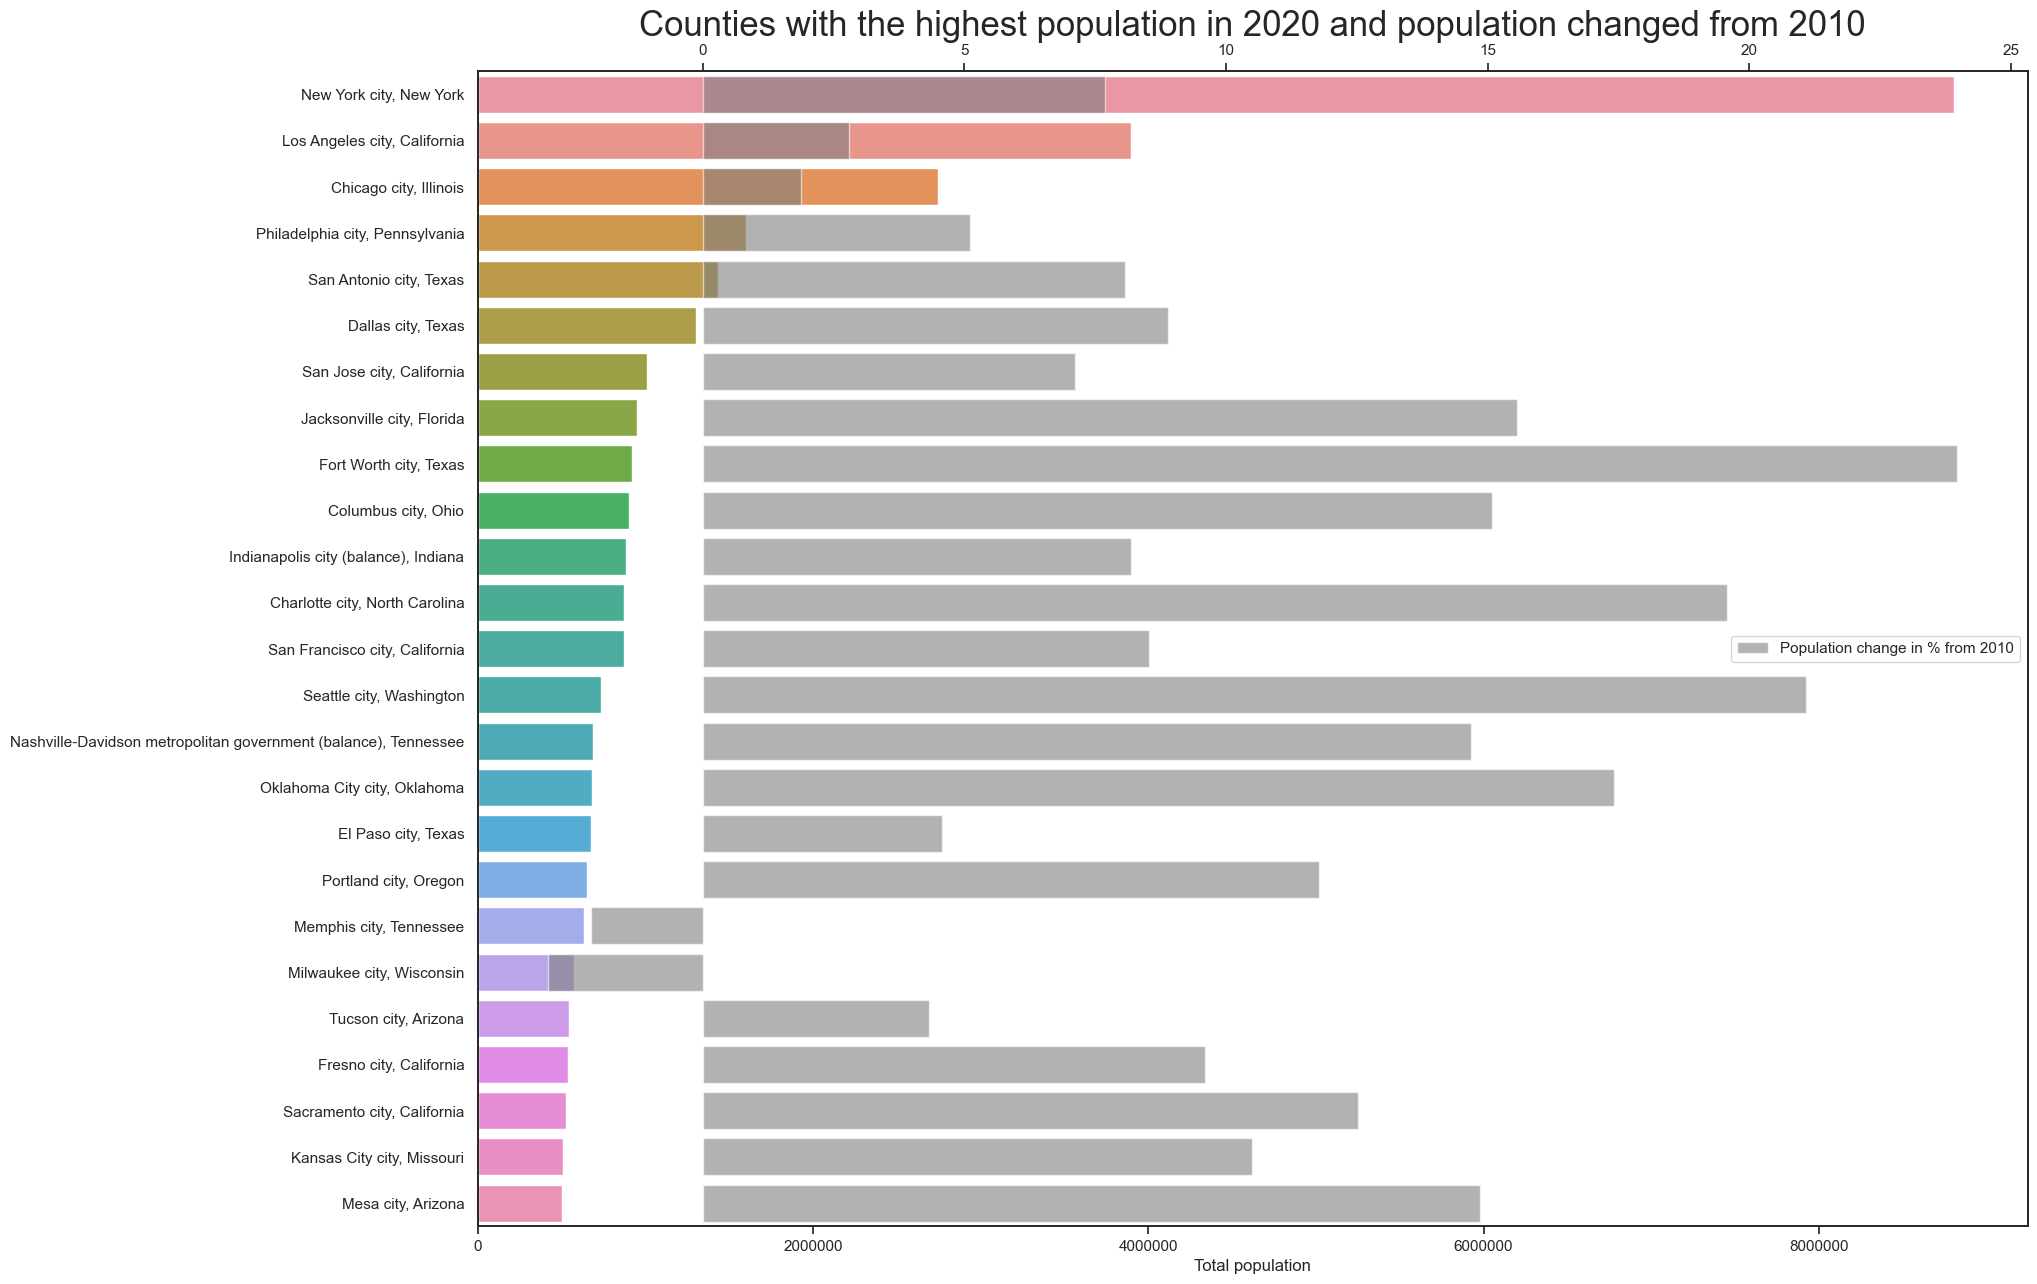

In [52]:
plt.figure(figsize=(20,15))
sns.set_theme(style="white", palette=None)
ax1 = sns.barplot(combined.query('total_20>500000').sort_values('total_20', ascending= False), y= 'city_state', x= 'total_20')
ax2 = plt.twiny()
sns.barplot(combined.query('total_20>500000').sort_values('total_20', ascending= False), y= 'city_state', x= 'total_change', ax = ax2, color = 'grey', alpha = 0.6, label = 'Population change in % from 2010')
ax2.spines['top'].set_position(('axes', 1.0))
plt.legend(loc = 'center right')
plt.title('Counties with the highest population in 2020 and population changed from 2010',  fontsize=25)
ax1.set_ylabel('')
plt.xlabel('hello')
ax1.set_xlabel('Total population')
ax2.set_xlabel('')
ax1.ticklabel_format(style='plain', axis='x')

Looking at the graph of counties with a population higher than 1 million in 2020. We can observe some trends. Counties with lower populations tend to have a higher rate of newcomers. Except for St. Louis county (where the city of St. Louis placed), Allegheny County (where the city of Pittsburgh places), Nassau County (site at Long Island, NY), and Suffolk County (next to Nassau County), all other counties has a higher than 5% increased in population, while Collin County, TX (next to Dallas) has an increase rate of 35%. On the other hand, the 2 counties with the top population, Los Angeles County and Cook County (where Chicago places) have a minimal increase, only 2%.

## Finding the relationship between change in county racial composition  and house price by looking at all counties

In [53]:
df_ch = combined.replace([np.inf, -np.inf], np.nan)
df_ch.dropna(inplace = True)

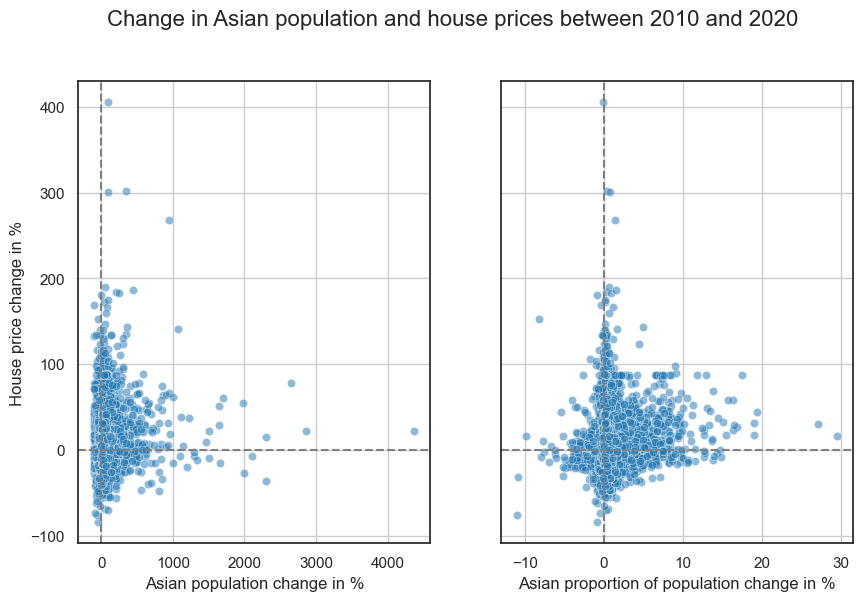

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch, x='as_change', y='adj_p_change', alpha = 0.5, ax = ax1)
sns.scatterplot(df_ch, x='as_p_change_20', y='adj_p_change', alpha = 0.5, ax = ax2)
sns.set_theme(style="whitegrid")
fig.suptitle('Change in Asian population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('Asian population change in %')
ax2.set_xlabel('Asian proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

In [55]:
pg.corr(df_ch['as_change'], df_ch['p_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,8202,0.155267,"[0.13, 0.18]",1.993116e-45,1.0


In [56]:
pg.corr(df_ch['as_p_change_20'], df_ch['p_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,8202,0.086253,"[0.06, 0.11]",5.080739e-15,1.0


In [57]:
pg.linear_regression(df_ch['as_change'], df_ch['p_change'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,16.187634,0.311927,51.895533,0.000000e+00,0.015214,0.015094,15.576178,16.799091
1,as_change,0.023849,0.002119,11.255494,3.558973e-29,0.015214,0.015094,0.019695,0.028003


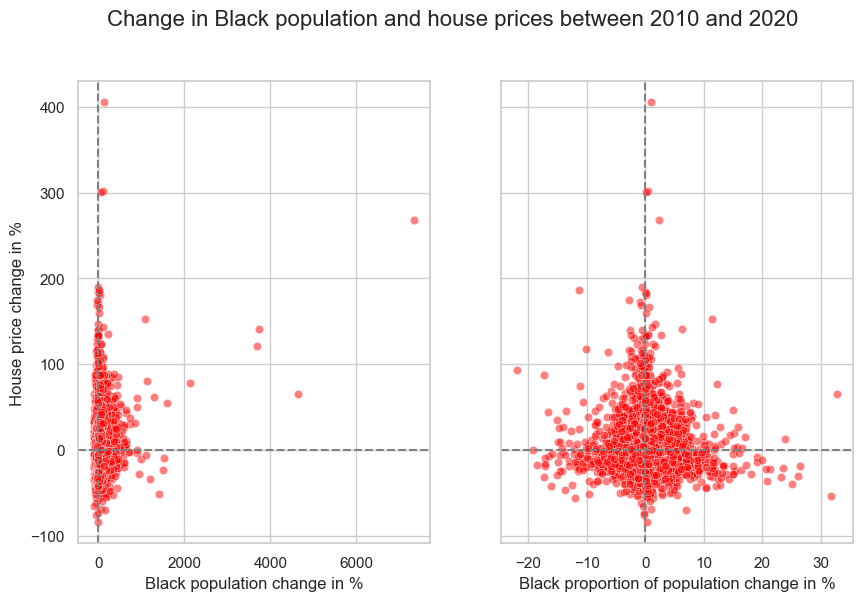

In [58]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch, x='bl_change', y='adj_p_change', alpha = 0.5, color = 'red', ax = ax1)
sns.scatterplot(df_ch, x='bl_p_change_20', y='adj_p_change', alpha = 0.5, color = 'red',ax = ax2)
fig.suptitle('Change in Black population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('Black population change in %')
ax2.set_xlabel('Black proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

In [59]:
pg.corr(df_ch['bl_change'], df_ch['p_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,8202,0.034342,"[0.01, 0.06]",0.001867,0.875149


In [60]:
pg.corr(df_ch['bl_p_change_20'], df_ch['p_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,8202,-0.068105,"[-0.09, -0.05]",6.651105e-10,0.999988


In [61]:
pg.linear_regression(df_ch['bl_change'], df_ch['p_change'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,16.458999,0.301378,54.612486,0.000000e+00,0.018509,0.01839,15.868222,17.049776
1,bl_change,0.024694,0.001986,12.435416,3.481044e-35,0.018509,0.01839,0.020801,0.028586


When we look the change in the black population, interestingly, it has a similar distribution compared to what we saw in the change in the Asian population. The result of the correlation test shows a 0.23 for R, which is larger than what we had in Asian population data and shows a positive, relatively weak, linear relationship. For the linear regression, we got a p-value that is smaller than 0.01, so, as well that there is very strong evidence again the null hypothesis, which is $\beta_1 = 0$, so we can say there is a positive relationship between change in the black population and change in house price.

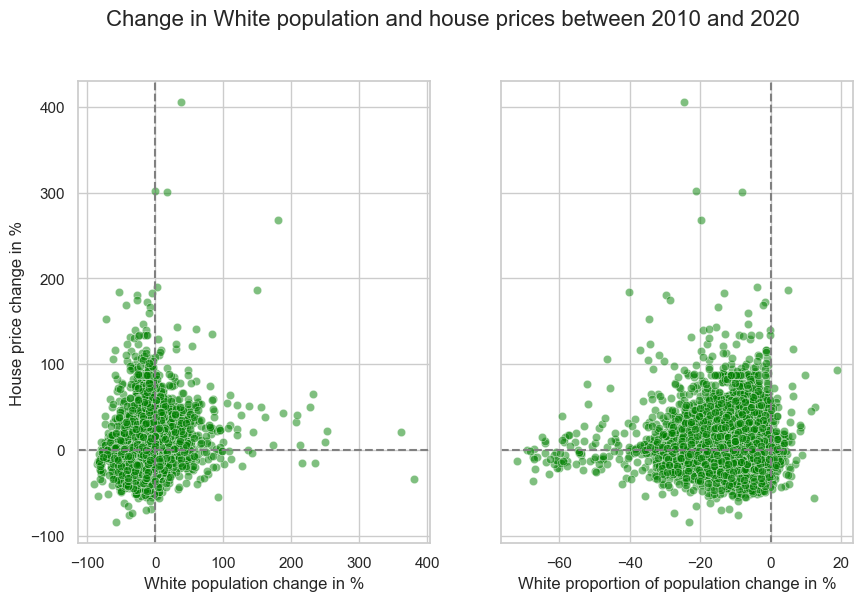

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch, x='wh_change', y='adj_p_change', alpha = 0.5, color = 'green', ax = ax1)
sns.scatterplot(df_ch, x='wh_p_change_20', y='adj_p_change', alpha = 0.5, color = 'green',ax = ax2)
fig.suptitle('Change in White population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('White population change in %')
ax2.set_xlabel('White proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

In [63]:
pg.corr(df_ch['wh_change'], df_ch['p_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,8202,0.179989,"[0.16, 0.2]",1.117517e-60,1.0


In [64]:
pg.linear_regression(df_ch['wh_change'], df_ch['p_change'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,18.689406,0.306376,61.001458,0.000000e+00,0.019692,0.019572,18.08883,19.289981
1,wh_change,0.161059,0.012549,12.834152,2.411413e-37,0.019692,0.019572,0.13646,0.185659


Here is something very different compared to what we saw in Asian and black population change, the population change does not vary that much since the white population is the majority in most counties, and it makes the correlation around 0.3, which is higher than the Asian and black population. For the omitted linear regression, we got a p-value that is smaller than 0.01, so, as well that there is very strong evidence again the null hypothesis, which is $\beta_1 = 0$, so we can say there is a positive relationship between change in the black population and change in house price.

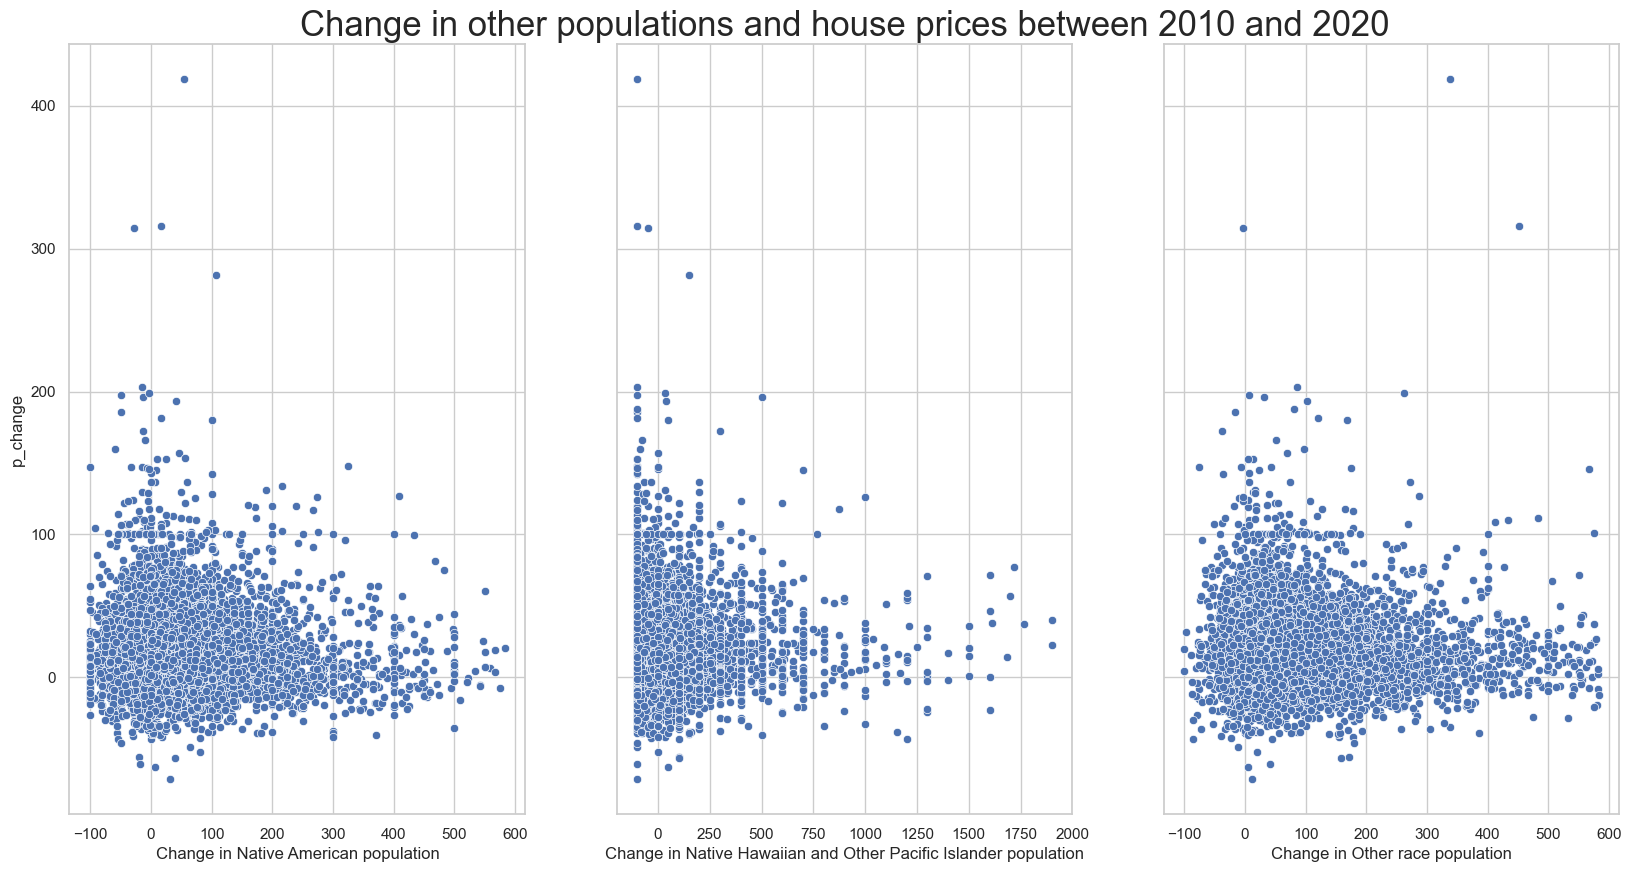

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20,10))
sns.scatterplot(df_ch.query('na_change<600'), x='na_change', y='p_change', ax=ax1)
sns.scatterplot(df_ch.query('ha_change<2000'), x='ha_change', y='p_change', ax=ax2)
sns.scatterplot(df_ch.query('o_change<600'), x='o_change', y='p_change', ax=ax3)
ax1.set_xlabel('Change in Native American population')
ax2.set_xlabel('Change in Native Hawaiian and Other Pacific Islander population')
ax3.set_xlabel('Change in Other race population')
ax2.set_title('Change in other populations and house prices between 2010 and 2020', loc='center', fontsize=25)
plt.show()

Because these groups only take up a very few proportions of each county's population, there are some big outliers in the graph, and I need to filter some of them, and they have some similar distribution compared to Asian and black. However, we will ignore them for some analysis because they only make up a small portion of the population.

In [66]:
print(df_ch.as_20.sum()/df_ch.total_20.sum()*100)
print(stats.percentileofscore(df_ch['as_20'],10000))

7.57433679010764
96.87881004633016


In [67]:
print(df_ch.query('as_20>10000').total_20.median())
print(stats.percentileofscore(df_ch['total_20'],111424))

111424.0
97.00073152889539


Looking at the data for this project, Asians took up about 6.3% of the total population in 2020. Although I only included one race, instead of some populations with two or more racial backgrounds, this number is very close to census data which is 6.2%. I want to look at the counties with Asian population higher than 100,000, which is around 98.2% percentile. And for counties with Asian population higher than 100,000, their median population is around 1.6 million in 2020.

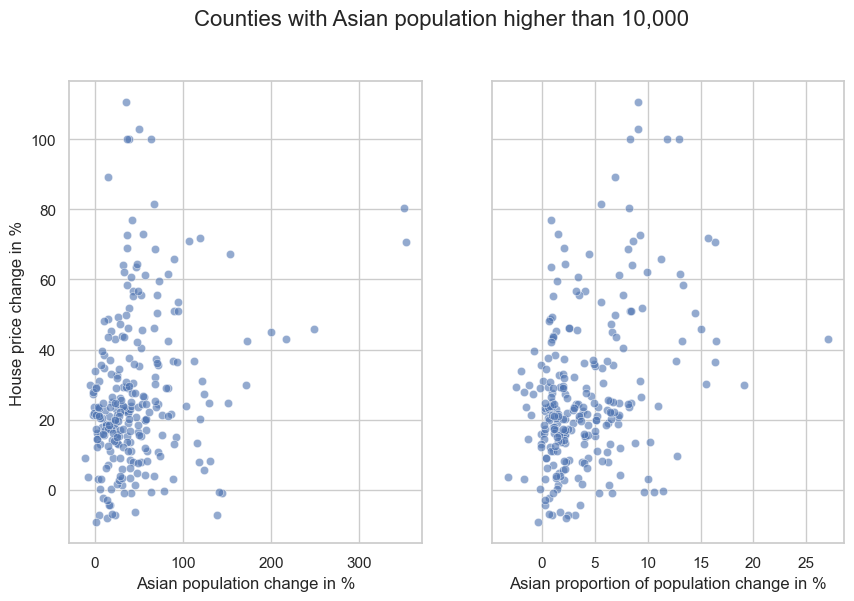

In [68]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch.query('as_20>10000'), x='as_change', y='p_change', alpha = 0.6, ax = ax1)
sns.scatterplot(df_ch.query('as_20>10000'), x='as_p_change_20', y='p_change', alpha = 0.6, ax = ax2)
sns.set_theme(style="whitegrid")
fig.suptitle('Counties with Asian population higher than 10,000 ', y=1, fontsize=16)
ax1.set_xlabel('Asian population change in %')
ax2.set_xlabel('Asian proportion of population change in %')
ax1.set_ylabel('House price change in %')
plt.show()

In [69]:
pg.corr(df_ch.query('as_20>10000')['as_change'],df_ch.query('as_20>10000')['p_change'] )

,n,r,CI95%,p-val,BF10,power
pearson,256,0.251042,"[0.13, 0.36]",0.000049,285.818,0.983315


In [70]:
pg.corr(df_ch.query('as_20>10000')['as_p_change_20'],df_ch.query('as_20>10000')['p_change'] )

,n,r,CI95%,p-val,BF10,power
pearson,256,0.359807,"[0.25, 0.46]",3.057729e-09,3.028e+06,0.999973


From the previous graphs created, we could not see a strong enough relationship when we look at all the counties in the US. What about counties with a higher population, since a small population in 2010 can make the percentage change very different compared to the already big Asian population? So I am now looking at the 256 cities with an Asian population higher than 10,000, from the scatter plot, there is a stronger positive relationship between Asian population change and house price change. The R we got is 0.251, which is moderate weak. The change in Asian proportion of population will have stronger positive relationship, having a R of 0.36. So by looking at the Asian population alone, it looks like big counties will have a higher correlation, what about other races? So I will now group all counties into four categoties based on total population in 2020 to find out the different relationship.

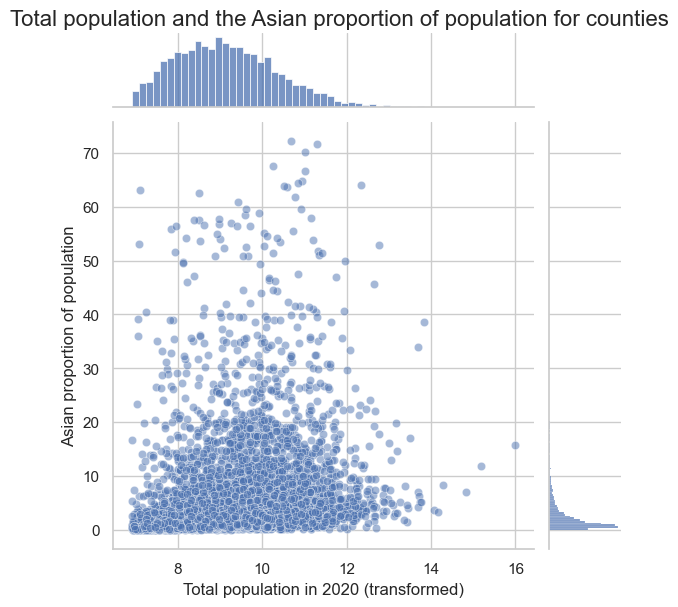

In [71]:
sns.jointplot(df_ch, x=np.log(df_ch['total_20']), y='as_p_20', alpha = 0.5)
plt.suptitle('Total population and the Asian proportion of population for counties', y=1.01, fontsize=16)
plt.xlabel('Total population in 2020 (transformed)')
plt.ylabel('Asian proportion of population')
plt.show()

In [72]:
print(df_ch.total_20.quantile(0.25))
print(df_ch.total_20.quantile(0.75))
print(df_ch.total_20.quantile(0.95))

3788.0
20468.75
79867.09999999999


After comparing with the histogram of the population and quantiles, I will use:
    small = population less than 3,788, which is around Q1
    medium = population less than 20,000 and above 3,788, which is around Q3
    large = population less than 80,000 and above 20,000, which is around 94% percentile
    very_large = population above 80,000

In [73]:
category_labels = ['small', 'medium', 'large', 'very_large']
bin_edges = [0, 3788, 20000, 80000, df_ch['total_20'].max()]
df_ch['city_size_20'] = pd.cut(df_ch['total_20'], bins=bin_edges, labels=category_labels)

In [74]:
df_ch.head()

,city_state,total_10,total_20,total_one_10,total_one_20,wh_10,wh_20,bl_10,bl_20,na_10,...,na_p_change_20,as_p_change_20,ha_p_change_20,o_p_change_20,hisp_p_change_20,p_10,p_20,p_change,adj_p_change,city_size_20
9,"Aberdeen city, Maryland",14959.0,16254.0,14166.0,14632.0,8815.0,8342.0,4564.0,5013.0,59.0,...,0.067013,0.111781,-0.119981,2.536667,-5.280655,227200.0,208000.0,-8.450704,-21.603414,medium
10,"Aberdeen city, Mississippi",5612.0,4961.0,5557.0,4829.0,1615.0,1257.0,3886.0,3513.0,6.0,...,0.094659,0.111026,-0.015481,0.001210,0.168919,67400.0,105400.0,56.379822,43.227113,medium
11,"Aberdeen city, South Dakota",26091.0,28495.0,25575.0,26988.0,23962.0,23825.0,178.0,553.0,945.0,...,0.045371,1.883440,-0.010071,1.740781,-4.169095,124200.0,170200.0,37.037037,23.884328,large
12,"Aberdeen city, Washington",16896.0,17013.0,16063.0,15169.0,13584.0,12282.0,135.0,223.0,617.0,...,0.356947,-0.036496,-0.078407,1.543463,-3.245838,139200.0,161100.0,15.732759,2.580049,medium
18,"Abingdon town, Virginia",8191.0,8376.0,8109.0,8016.0,7681.0,7530.0,257.0,246.0,15.0,...,-0.004045,0.931920,-0.073251,-0.076952,0.456401,175300.0,185300.0,5.704507,-7.448203,medium


In [75]:
df_ch.groupby('city_size_20').size()

city_size_20
small         2052
medium        4052
large         1688
very_large     410
dtype: int64

Now we see there is 2052 small city, 4052 medium city, 1688 large city, and 410 very large city. Before doing everything, we want to find out whether there is a different distribution on price change for city size. By looking at the graph below, looking at the adjusted price change, except for city size, which is very large, they have a median slightly less than 0, which is the population median with a right-skewed distribution. But things changed for counties that are very large. Its median is higher than the population median and has a more uniform distribution. It is more fun to look at the very large counties.

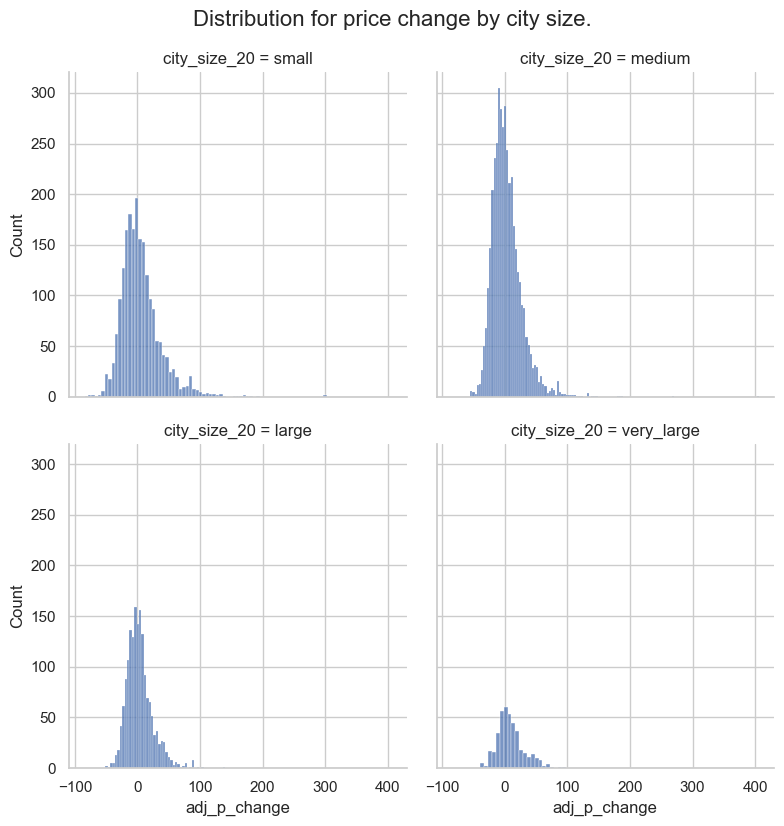

In [76]:
g = sns.FacetGrid(df_ch, col='city_size_20', height=4, col_wrap=2)
g.map(sns.histplot, "adj_p_change")
plt.suptitle('Distribution for price change by city size.', y = 1.03, fontsize = 16)
plt.show()

In [77]:
pg.kruskal(data=df_ch, dv='p_change', between='city_size_20',detailed=True).round(4)

,Source,ddof1,H,p-unc
Kruskal,city_size_20,3,41.7533,0.0


The Kruskal-Wallis test (since we have different distribution for each groups)supports our finding from the graph, in which the p-value is smaller than 0.01. There is strong evidence that indicates the mean price change is different between counties.

In [78]:
pg.pairwise_gameshowell(data=df_ch, dv='p_change', between='city_size_20').round(4)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,small,medium,18.7799,16.6427,2.1372,0.8343,2.5617,3280.4452,0.0512,0.0694
1,small,large,18.7799,16.4519,2.3279,0.8929,2.6071,3508.7924,0.0453,0.0857
2,small,very_large,18.7799,22.7636,-3.9837,1.2951,-3.0759,849.8478,0.0116,-0.1663
3,medium,large,16.6427,16.4519,0.1908,0.6447,0.2959,3780.4410,0.9910,0.0086
4,medium,very_large,16.6427,22.7636,-6.1209,1.1383,-5.3774,528.6905,0.0000,-0.2786
5,large,very_large,16.4519,22.7636,-6.3117,1.1819,-5.3402,608.1566,0.0000,-0.2939


After doing the post hoc test, we can see from the result that the very large counties do have a significant difference in mean house price change where all the p-value with very_large included is lower than 0.01.

Now we find enough evidence, we should zoom in and looking at the relationship in very large city only.

## Look at the relationship between population change and horse price change for counties with a very large population.

In [79]:
very_large = df_ch.query("city_size_20 == 'very_large'")

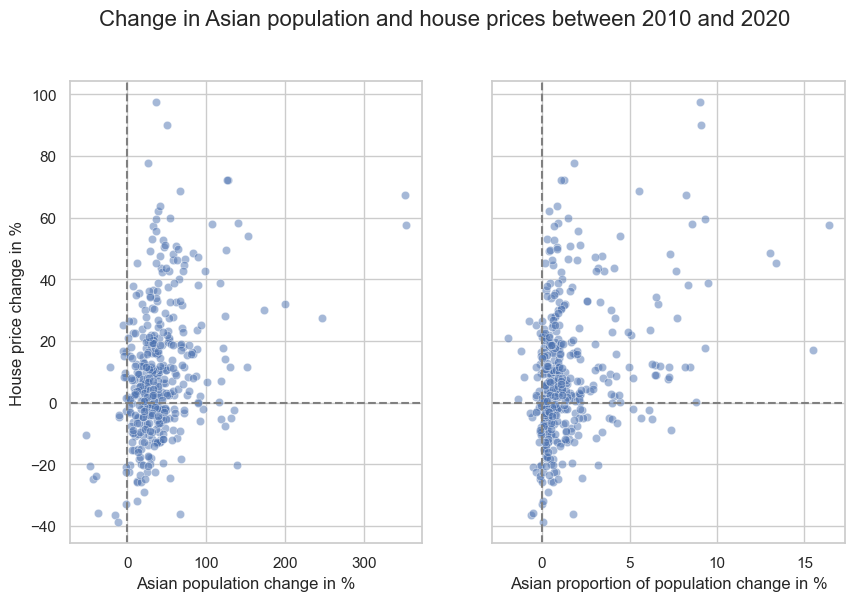

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(very_large, x='as_change', y='adj_p_change', alpha = 0.5, ax = ax1)
sns.scatterplot(very_large, x='as_p_change_20', y='adj_p_change', alpha = 0.5, ax = ax2)
sns.set_theme(style="whitegrid")
fig.suptitle('Change in Asian population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('Asian population change in %')
ax2.set_xlabel('Asian proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

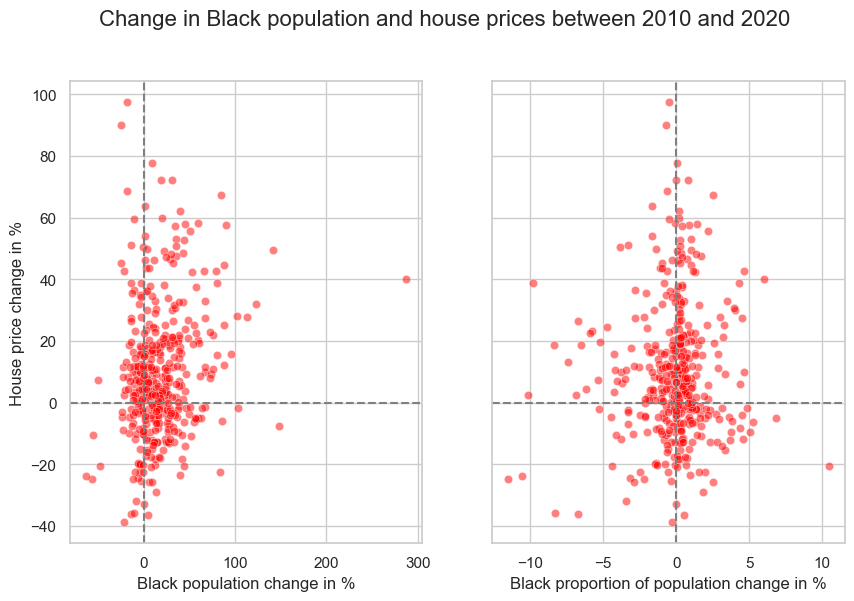

In [81]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(very_large, x='bl_change', y='adj_p_change', alpha = 0.5, color = 'red', ax = ax1)
sns.scatterplot(very_large, x='bl_p_change_20', y='adj_p_change', alpha = 0.5, color = 'red',ax = ax2)
fig.suptitle('Change in Black population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('Black population change in %')
ax2.set_xlabel('Black proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

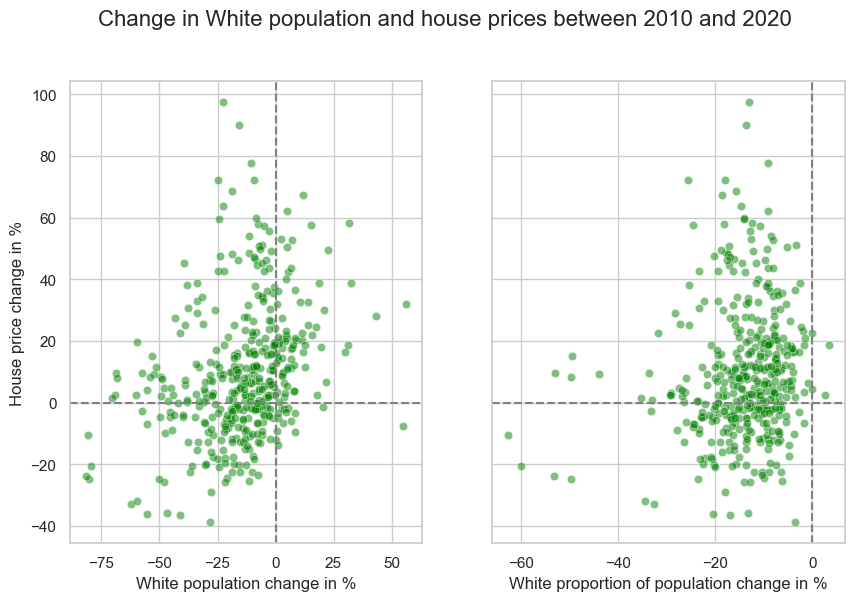

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(very_large, x='wh_change', y='adj_p_change', alpha = 0.5, color = 'green', ax = ax1)
sns.scatterplot(very_large, x='wh_p_change_20', y='adj_p_change', alpha = 0.5, color = 'green',ax = ax2)
fig.suptitle('Change in White population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('White population change in %')
ax2.set_xlabel('White proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

In [83]:
pg.linear_regression(very_large[['wh_change','as_change','bl_change']], very_large['p_change']).round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,19.6340,1.9846,9.8933,0.0000,0.1675,0.1613,15.7327,23.5353
1,wh_change,0.2123,0.0582,3.6456,0.0003,0.1675,0.1613,0.0978,0.3268
2,as_change,0.1513,0.0275,5.4972,0.0000,0.1675,0.1613,0.0972,0.2055
3,bl_change,-0.0008,0.0363,-0.0221,0.9824,0.1675,0.1613,-0.0722,0.0706


What a surprising result! The coefficient for change in the black population is least significant compared to the change in the white and Asian populations. Where the p-value for wh_change and as_change is smaller than 0.01, we can say there is strong evidence that in city that have a population higher than half-million, there is a correlation between change in population for white and Asian, which for white change is 0.212, and Asian change iss 0.151.

In [84]:
pg.linear_regression(very_large[['wh_p_change_20','as_p_change_20','bl_p_change_20']], very_large['p_change']).round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,23.2573,1.9900,11.6870,0.0000,0.1377,0.1314,19.3453,27.1693
1,wh_p_change_20,0.3893,0.1153,3.3755,0.0008,0.1377,0.1314,0.1626,0.6161
2,as_p_change_20,3.0697,0.4125,7.4425,0.0000,0.1377,0.1314,2.2589,3.8806
3,bl_p_change_20,0.1298,0.4181,0.3104,0.7564,0.1377,0.1314,-0.6922,0.9517


Similar to what we had for the change in population, the change in the porpotion of the population for the white group and Asian group has a p-value less than 0.01, and the change in the porpotion of the population for the black group has a p-value larger than 0.1, which shows little to no evidence that there is a relationship between change in the proportion of the population for black group and change on house price. And compared to the coefficient for change in the population proportion of Asian and white, Asian has a much larger coefficient which is 3.07, which means that when there is a 1 percent change in the proportion of the population of the Asian group, there will be a 3.07% change in house price in one city.

## Overall view: racial demographics and house price

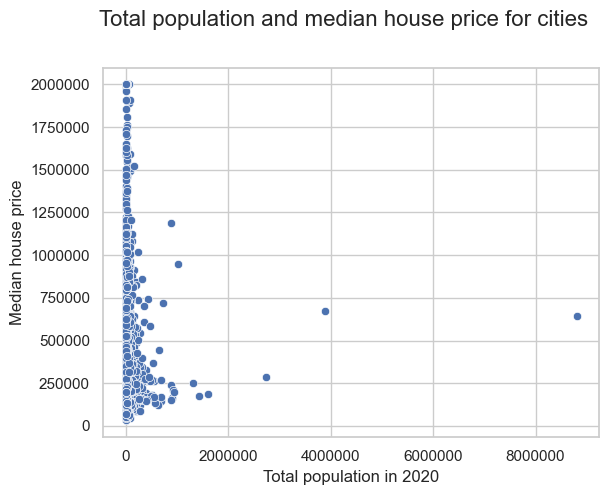

In [85]:
sns.scatterplot(df_ch, x=df_ch['total_20'], y=df_ch['p_20'])
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.suptitle('Total population and median house price for cities', y=1, fontsize=16)
plt.xlabel('Total population in 2020')
plt.ylabel('Median house price')
plt.show()

That doesn't show us too much relationship between total population and median house price. It makes sense that some small cities with many mansions will have a high median house price. Now we need to transform them using log, and we will be able to see a much strong relationship.

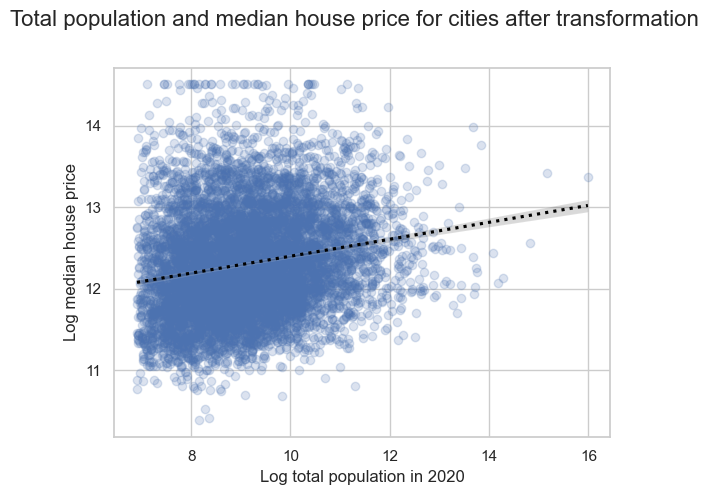

In [86]:
sns.regplot(df_ch, x=np.log(df_ch['total_20']), y=np.log(df_ch['p_20']), scatter_kws={"alpha": 0.2}, line_kws={"color": "black", 'linestyle':':'})
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.suptitle('Total population and median house price for cities after transformation', y=1, fontsize=16)
plt.xlabel('Log total population in 2020')
plt.ylabel('Log median house price')
plt.show()

In [87]:
pg.corr(np.log(df_ch['total_20']), np.log(df_ch['p_20']))

,n,r,CI95%,p-val,BF10,power
pearson,8202,0.19487,"[0.17, 0.22]",5.235324e-71,1.146e+67,1.0


In [88]:
pg.linear_regression(np.log(df_ch['total_20']), np.log(df_ch['p_20'])).round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,11.3598,0.0533,213.0422,0.0,0.038,0.0379,11.2553,11.4644
1,total_20,0.1039,0.0058,17.9912,0.0,0.038,0.0379,0.0926,0.1153


Finally! After trying different stuff, we see a practical OLS model. We got a p-value that is much smaller than 0.01, indicating that we have very strong evidence against the null hypothesis that there is no relationship between the percentage change in total population for cities in 2020 and the percentage change in median house prices in 2020. From the result above, we can estimate that when there is a 1% change in the total population, the median house price will go up by 0.1%.

Since my main goal is to find the relationship between racial demographics and house prices, let's take a look at the Asian population's proportion and house prices. From the graph below, we can see some positive, linear relationships between them. However, the data cluster in between 0 - 10 percent of the city population; we should try something else, like only looking at cities with very big populations.

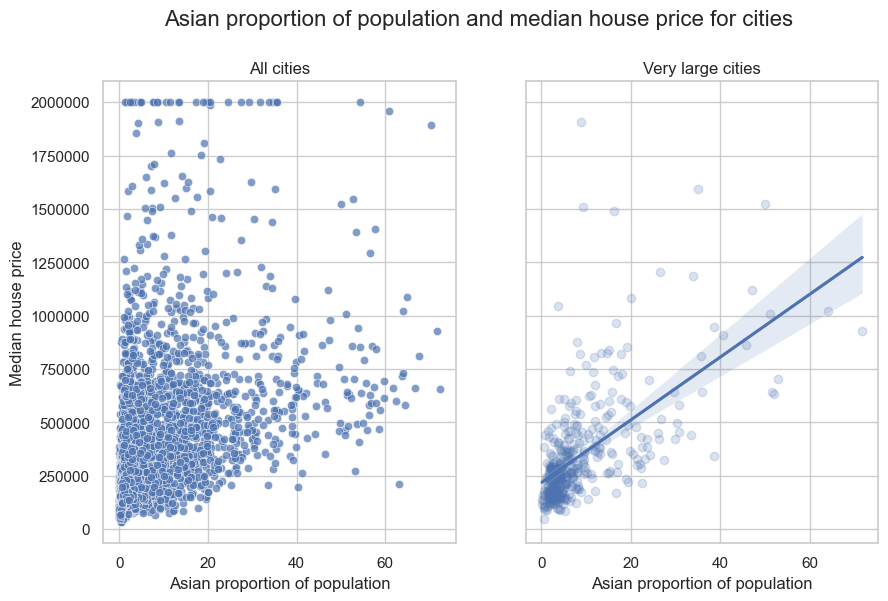

In [89]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch, x=df_ch['as_p_20'], y=df_ch['p_20'], alpha = 0.7, ax = ax1)
sns.regplot(df_ch, x=df_ch.query("city_size_20 == 'very_large'")['as_p_20'], y=df_ch.query("city_size_20 == 'very_large'")['p_20'],scatter_kws={"alpha": 0.2}, ax = ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Asian proportion of population and median house price for cities', y=1, fontsize=16)
ax1.set_title('All cities', y=1, fontsize=12)
ax2.set_title('Very large cities', y=1, fontsize=12)
ax1.set_xlabel('Asian proportion of population')
ax2.set_xlabel('Asian proportion of population')
ax1.set_ylabel('Median house price')
ax2.set_ylabel('')
plt.show()

Now it looks good!

In [90]:
pg.corr(df_ch.query("city_size_20 == 'very_large'")['as_p_20'], df_ch.query("city_size_20 == 'very_large'")['p_20'])

,n,r,CI95%,p-val,BF10,power
pearson,410,0.607215,"[0.54, 0.66]",1.142556e-42,2.222e+39,1.0


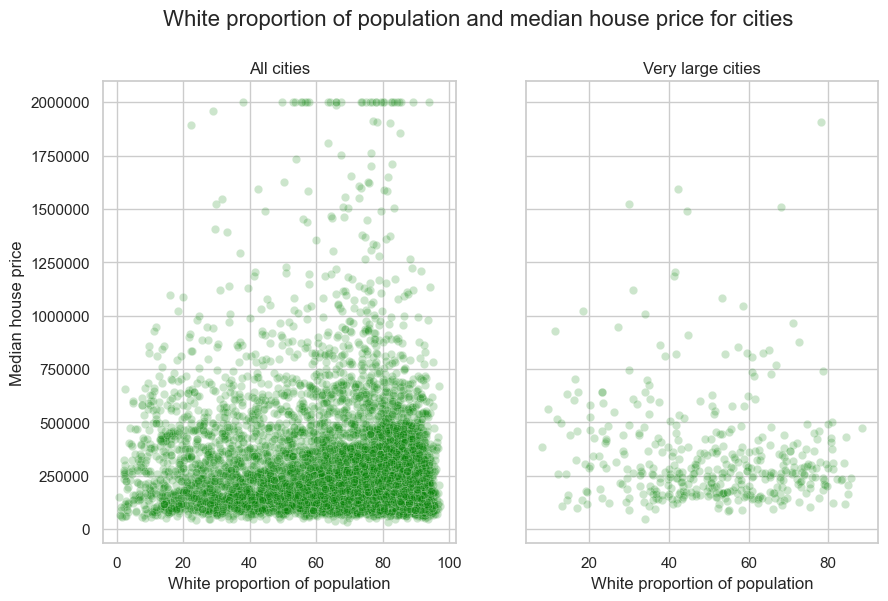

In [91]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch, x=df_ch['wh_p_20'], y=df_ch['p_20'], alpha = 0.2, ax = ax1, color = 'green')
sns.scatterplot(df_ch, x=df_ch.query("city_size_20 == 'very_large'")['wh_p_20'], y=df_ch.query("city_size_20 == 'very_large'")['p_20'], alpha = 0.2, color = 'green', ax = ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('White proportion of population and median house price for cities', y=1, fontsize=16)
ax1.set_title('All cities', y=1, fontsize=12)
ax2.set_title('Very large cities', y=1, fontsize=12)
ax1.set_xlabel('White proportion of population')
ax2.set_xlabel('White proportion of population')
ax1.set_ylabel('Median house price')
plt.show()

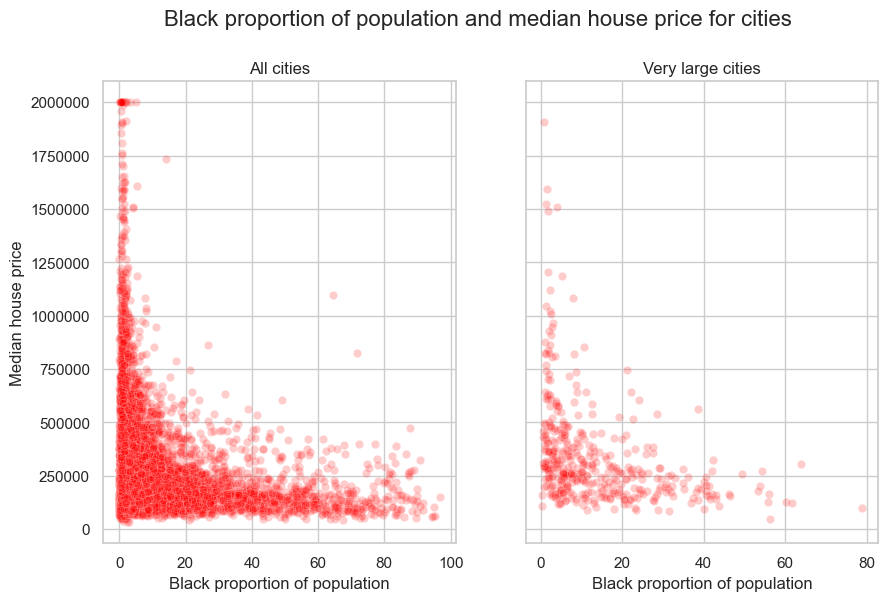

In [92]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch, x=df_ch['bl_p_20'], y=df_ch['p_20'], alpha = 0.2, ax = ax1, color = 'red')
sns.scatterplot(df_ch, x=df_ch.query("city_size_20 == 'very_large'")['bl_p_20'], y=df_ch.query("city_size_20 == 'very_large'")['p_20'], alpha = 0.2, color = 'red', ax = ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Black proportion of population and median house price for cities', y=1, fontsize=16)
ax1.set_title('All cities', y=1, fontsize=12)
ax2.set_title('Very large cities', y=1, fontsize=12)
ax1.set_xlabel('Black proportion of population')
ax2.set_xlabel('Black proportion of population')
ax1.set_ylabel('Median house price')
plt.show()

In [93]:
print('Correlation between black proportion of population and change in house price in all cities:\n', pg.corr(x=df_ch['bl_p_20'], y=df_ch['p_20']))
print('Correlation between black proportion of population and percentage change in house price in all cities:\n', pg.corr(x=df_ch['bl_p_20'], y=np.log(df_ch['p_20'])))

Correlation between black proportion of population and change in house price in all cities:
             n        r           CI95%         p-val       BF10  power
pearson  8202 -0.19729  [-0.22, -0.18]  9.050417e-73  6.543e+68    1.0
Correlation between black proportion of population and percentage change in house price in all cities:
             n         r           CI95%          p-val       BF10  power
pearson  8202 -0.241021  [-0.26, -0.22]  9.969149e-109  4.77e+104    1.0


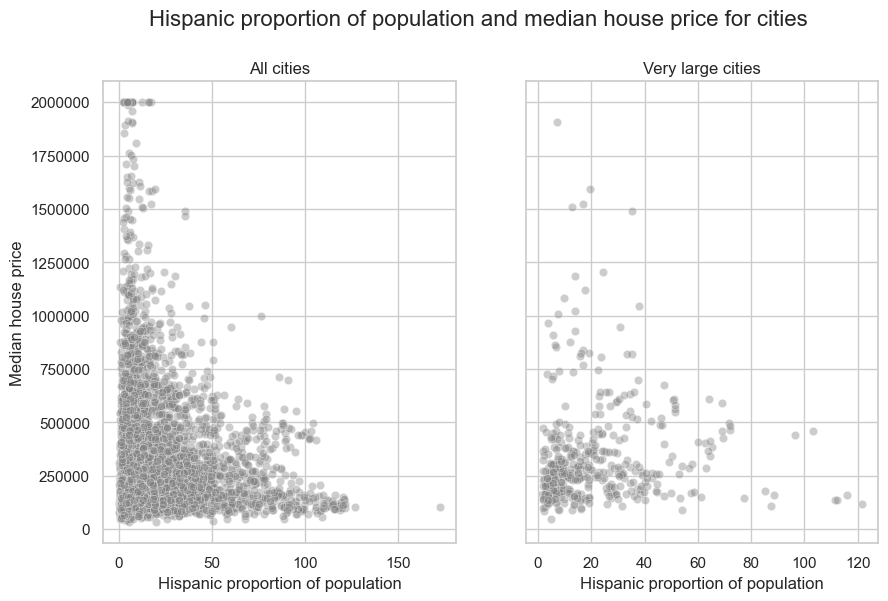

In [94]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch, x=df_ch['hisp_p_20'], y=df_ch['p_20'], alpha=0.4, ax=ax1, color='grey')
sns.scatterplot(df_ch, x=df_ch.query("city_size_20 == 'very_large'")['hisp_p_20'],
                y=df_ch.query("city_size_20 == 'very_large'")['p_20'], alpha=0.4, color='grey', ax=ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Hispanic proportion of population and median house price for cities', y=1, fontsize=16)
ax1.set_title('All cities', y=1, fontsize=12)
ax2.set_title('Very large cities', y=1, fontsize=12)
ax1.set_xlabel('Hispanic proportion of population')
ax2.set_xlabel('Hispanic proportion of population')
ax1.set_ylabel('Median house price')
plt.show()

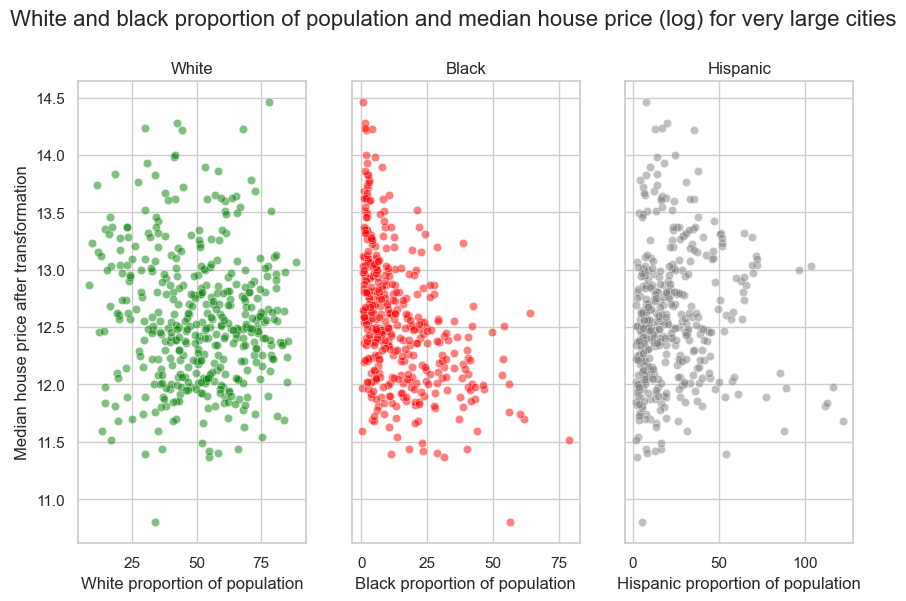

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(df_ch, x=df_ch.query("city_size_20 == 'very_large'")['wh_p_20'], y=np.log(df_ch.query("city_size_20 == 'very_large'")['p_20']), alpha = 0.5, color = 'green', ax =ax1)
sns.scatterplot(df_ch, x=df_ch.query("city_size_20 == 'very_large'")['bl_p_20'], y=np.log(df_ch.query("city_size_20 == 'very_large'")['p_20']), alpha = 0.5, color = 'red', ax =ax2)
sns.scatterplot(df_ch, x=df_ch.query("city_size_20 == 'very_large'")['hisp_p_20'], y=np.log(df_ch.query("city_size_20 == 'very_large'")['p_20']), alpha = 0.5, color = 'grey', ax =ax3)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('White and black proportion of population and median house price (log) for very large cities', y=1, fontsize=16)
ax1.set_title('White', y=1, fontsize=12)
ax2.set_title('Black', y=1, fontsize=12)
ax3.set_title('Hispanic', y=1, fontsize=12)
ax1.set_xlabel('White proportion of population')
ax2.set_xlabel('Black proportion of population')
ax3.set_xlabel('Hispanic proportion of population')
ax1.set_ylabel('Median house price after transformation')
plt.show()

In [96]:
print('Correlation between white proportion of population and change in house price in very large cities:\n', pg.corr(x=df_ch.query("city_size_20 == 'very_large'")['wh_p_20'], y=df_ch.query("city_size_20 == 'very_large'")['p_20']),'\n')
print('Correlation between black proportion of population and change in house price in very large cities:\n', pg.corr(x=df_ch.query("city_size_20 == 'very_large'")['bl_p_20'], y=df_ch.query("city_size_20 == 'very_large'")['p_20']))

Correlation between white proportion of population and change in house price in very large cities:
            n         r         CI95%     p-val   BF10     power
pearson  410 -0.100635  [-0.2, -0.0]  0.041685  0.488  0.531639 

Correlation between black proportion of population and change in house price in very large cities:
            n         r           CI95%         p-val       BF10  power
pearson  410 -0.373583  [-0.45, -0.29]  5.014601e-15  1.107e+12    1.0


In [97]:
print('Correlation between white proportion of population and percentage change in house price in very large cities:\n', pg.corr(x=df_ch.query("city_size_20 == 'very_large'")['wh_p_20'], y=np.log(df_ch.query("city_size_20 == 'very_large'")['p_20'])),'\n')
print('Correlation between black proportion of population and percentage change in house price in very large cities:\n', pg.corr(x=df_ch.query("city_size_20 == 'very_large'")['bl_p_20'], y=np.log(df_ch.query("city_size_20 == 'very_large'")['p_20'])))

Correlation between white proportion of population and percentage change in house price in very large cities:
            n        r          CI95%     p-val   BF10     power
pearson  410 -0.08813  [-0.18, 0.01]  0.074665  0.301  0.430415 

Correlation between black proportion of population and percentage change in house price in very large cities:
            n         r           CI95%         p-val       BF10  power
pearson  410 -0.454918  [-0.53, -0.37]  2.464332e-22  1.716e+19    1.0


In [98]:
pg.linear_regression(very_large[['as_p_20','bl_p_20']], very_large['p_20']).round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,289832.9731,16940.1665,17.1092,0.0,0.4226,0.4198,256531.8289,323134.1173
1,as_p_20,13305.7987,941.9615,14.1256,0.0,0.4226,0.4198,11454.0816,15157.5157
2,bl_p_20,-4389.9014,712.0885,-6.1648,0.0,0.4226,0.4198,-5789.7319,-2990.0710


Here is a regression if we ignore other racial groups. For very large cities, the proportion of the population for Asian and black have a p-value smaller than 0.01, which means there is very strong evidence to suggest it. If we look at the coefficient, the Asian proportion has a 13305.8 value, which indicates that 1 percent increase in the Asian proportion of the population in a very large city,  the median house price will increase by 13305.8 in 2020. In contrast, the coefficient for the black population is -4390, which indicates a 1 percent increase of the black proportion of the population in a very large city, the median house price will decrease by 4390 in 2020.

In [99]:
pg.linear_regression(very_large[['as_p_10','bl_p_10']], very_large['p_10']).round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,241590.7610,11558.0769,20.9023,0.0,0.3791,0.376,218869.7809,264311.7412
1,as_p_10,10185.9583,777.5659,13.0998,0.0,0.3791,0.376,8657.4117,11714.5050
2,bl_p_10,-2602.6603,479.8825,-5.4235,0.0,0.3791,0.376,-3546.0181,-1659.3026


Here is the regression for 2010 with the same feature, we can see the coefficient for the Asian population is 10186, and the coefficient for the black population is -2602.7, which is smaller if we look at their absolute values.

The result for the Asian proportion of the population can be identified as a strong, positive, and linear relationship with median house prices, but what about the white and black groups? The result looks like there is a weak, negative, linear relationship between the proportion of the population and the change in median house prices. For both original data and transformed data, it looks like there is a slightly higher correlation between the white proportion of the population to the black proportion of the population.

## Machine learning practice: predict house price level by racial demographics

We want to ask python to predict the price level, it will be a discrete categorical data, so we need to put median house price for each city into group.

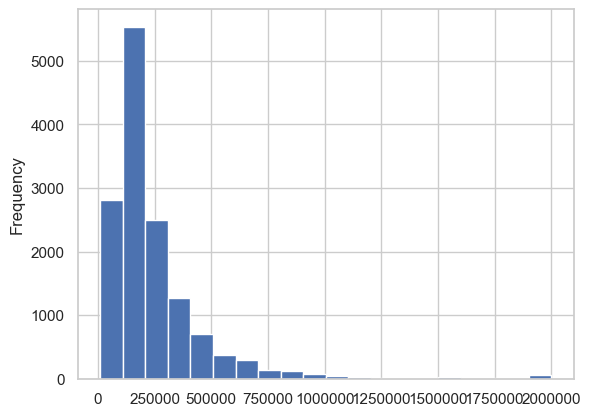

In [100]:
combined.p_20.plot(kind = 'hist', bins = 20)
plt.ticklabel_format(style='plain', axis='x')

In [101]:
combined.p_20.quantile(0.9)

473720.00000000006

After comparing with the histogram of the median house price, I will use:
    lowest = median house price less than 140,000, which is around 40% percentile
    low = median house price less than 210,000 and above 140,000, which is around 60% percentile
    medium = median house price less than 300,000 and above 210,000, which is around 76% percentile
    high = median house price less than 470,000 and above 300,000, which is around 90% percentile
    very_large = median house price above 470,000

In [102]:
category_labels = ['lowest', 'low', 'medium','high', 'highest']
bin_edges = [0, 140000, 210000, 300000, 470000, combined['p_20'].max()]
combined['price_level'] = pd.cut(combined['p_20'], bins=bin_edges, labels=category_labels)

In [103]:
combined.head()

,city_state,total_10,total_20,total_one_10,total_one_20,wh_10,wh_20,bl_10,bl_20,na_10,...,na_p_change_20,as_p_change_20,ha_p_change_20,o_p_change_20,hisp_p_change_20,p_10,p_20,p_change,adj_p_change,price_level
0,"Abbeville city, Alabama",2688.0,2358.0,2657.0,2275.0,1463.0,1165.0,1113.0,1039.0,2.0,...,0.137639,-0.331130,0.000000,0.191124,0.984964,92900.0,98600.0,6.135630,-7.017080,lowest
1,"Abbeville city, Georgia",2908.0,2685.0,2859.0,2657.0,1191.0,963.0,1624.0,1639.0,3.0,...,-0.103164,-0.183479,0.000000,0.821992,3.084844,29200.0,53300.0,82.534247,69.381537,lowest
2,"Abbeville city, Louisiana",12257.0,11186.0,12011.0,10694.0,6132.0,5054.0,5029.0,4776.0,32.0,...,0.114394,0.326171,0.008940,0.339624,-0.147983,76500.0,96900.0,26.666667,13.513957,lowest
3,"Abbeville city, South Carolina",5237.0,4874.0,5158.0,4703.0,2458.0,2389.0,2645.0,2275.0,10.0,...,-0.088364,-0.275047,0.041034,0.072321,-0.008117,90200.0,97000.0,7.538803,-5.613907,lowest
4,"Abbotsford city, Wisconsin",2310.0,2275.0,2298.0,2015.0,1893.0,1500.0,2.0,12.0,8.0,...,0.225108,0.142524,0.000000,4.296370,-12.515485,109900.0,112500.0,2.365787,-10.786922,lowest


In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [105]:
combined['state_code'] = combined.state.astype('category').cat.codes

AttributeError: 'DataFrame' object has no attribute 'state'

In [ ]:
features = ['wh_p_20','bl_p_20','as_p_20','na_p_20','ha_p_20','o_p_20','hisp_p_20', 'total_20']
X = combined[features]
y = combined['price_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [ ]:
dtc_model = DecisionTreeClassifier(random_state = 1)
dtc_model.fit(X_train, y_train)
y_pred = dtc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("DTC Accuracy: {:.2f}%".format(accuracy*100))

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
max_features = ['sqrt', 'log2']
criterion = ['gini', 'entropy']

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator = rf, param_distributions = {'n_estimators': n_estimators,
                                               'max_depth': max_depth,
                                               'min_samples_split': min_samples_split,
                                               'max_features': max_features,
                                               'criterion': criterion},
                          n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

In [ ]:
rf_model = RandomForestClassifier(random_state = 1, n_estimators = 500, min_samples_split = 10, max_features = 'log2', max_depth =90, criterion = 'gini')
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("RF Accuracy: {:.2f}%".format(accuracy*100))

In [ ]:
rf_model.predict([[1,71,11.1,7.6,0.02,0.03,5.5, 90]])

In [ ]:
X_test.head()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
features = ['wh_p_20','bl_p_20','as_p_20','na_p_20','ha_p_20','o_p_20','hisp_p_20', 'total_20']
X = combined[features]
y = combined['p_20']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [ ]:
rf_model = RandomForestRegressor(random_state=1, max_depth = None, min_samples_leaf =2, min_samples_split = 2, n_estimators = 150 )
rf_model.fit(X_train, y_train)
rf_val_predictions = rf_model.predict(X_test)
rf_val_mae = mean_absolute_error(rf_val_predictions, y_test)
print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error'
)
grid_search.fit(X, y)

print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)